# Score the inputs for parent-specific filters later

In [2]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


In [2]:
os.chdir("/home/broerman/projects/crispy_shifty")
sys.path.insert(0, os.getcwd())

In [7]:
input_dhrs = [os.path.join(os.getcwd(), 'projects/crispy_shifty_dimers/00_inputs/original_dhr.list'),
              os.path.join(os.getcwd(), 'projects/crispy_shifty_dimers/00_inputs/tj_DHRs_filtered_filtered.list')]
input_thrs = [os.path.join(os.getcwd(), 'projects/crispy_shifty_dimers/00_inputs/original_thr.list')]

def create_tasks():
    for list_file in input_dhrs:
        with open(list_file, "r") as f:
            for file in f:
                file = file.rstrip()
                tasks = {}
                tasks["pdb_path"] = file
                tasks["pre_break_helix"] = 4 # use kwargs to match the right pre_break_helix with the right scaffold type
                tasks["name"] = file.split('/')[-1][:-4]
                yield tasks

    for list_file in input_thrs:
        with open(list_file, "r") as f:
            for file in f:
                file = file.rstrip()
                tasks = {}
                tasks["pdb_path"] = file
                tasks["pre_break_helix"] = 6 # use kwargs to match the right pre_break_helix with the right scaffold type
                tasks["name"] = file.split('/')[-1][:-4]
                yield tasks

In [8]:
with open(input_dhrs[1], 'r') as f:
    print(len(f.readlines()))

190


In [14]:
# Python standard library
from typing import *

# 3rd party library imports
# Rosetta library imports
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.rosetta.core.pose import Pose

def measure_CA_dist(pose: Pose, resi_a: int, resi_b: int) -> float:
    resi_a_coords = pose.residue(resi_a).xyz("CA")
    resi_b_coords = pose.residue(resi_b).xyz("CA")
    dist = resi_a_coords.distance(resi_b_coords)
    return dist


def helix_dict_maker(pose: Pose) -> dict:
    """
    Make a dictionary mapping of residue indices to the helix indices.
    Keys are helix indices, values are lists of residue indices.
    """
    import pyrosetta

    ss = pyrosetta.rosetta.core.scoring.dssp.Dssp(pose)
    helix_dict = {}
    n = 1
    for i in range(1, len(pose.sequence())):
        if (ss.get_dssp_secstruct(i) == "H") & (ss.get_dssp_secstruct(i - 1) != "H"):
            helix_dict[n] = [i]
        if (ss.get_dssp_secstruct(i) == "H") & (ss.get_dssp_secstruct(i + 1) != "H"):
            helix_dict[n].append(i)
            n += 1
    return helix_dict


def get_helix_endpoints(pose: Pose, n_terminal: bool) -> dict:
    """
    Make a dictionary of the start (n_terminal=True) or end residue indices of each helix
    """
    helix_dict = helix_dict_maker(pose)
    helix_endpoints = {}
    if n_terminal:
        index = 0  # helix start residue
    else:
        index = -1  # helix end residue
    for helix, residue_list in helix_dict.items():
        helix_endpoints[helix] = residue_list[index]
    return helix_endpoints


def combine_two_poses(
    pose_a: Pose,
    pose_b: Pose,
    end_a: int,
    start_b: int,
) -> Pose:
    """
    Make a new pose, containing pose_a up to end_a, then pose_b starting from start_b
    Assumes pose_a has only one chain.
    """
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose

    length = len(pose_a.sequence())
    newpose = Pose()
    for i in range(1, end_a + 1):
        newpose.append_residue_by_bond(pose_a.residue(i))
    newpose.append_residue_by_jump(
        pose_b.residue(start_b), newpose.chain_end(1), "CA", "CA", 1
    )
    for i in range(start_b + 1, length + 1):
        newpose.append_residue_by_bond(pose_b.residue(i))
    return newpose

def score_inputs(output_scorefile, **kwargs):

    import collections
    import json
    from time import time
    import pyrosetta
    import pyrosetta.distributed.io as io
    from crispy_shifty.protocols.cleaning import path_to_pose_or_ppose
    from crispy_shifty.protocols.design import score_cms, score_sc, score_ss_sc, score_on_chain_subset, score_per_res, score_wnm_all, score_wnm_helix, gen_score_filter

    # testing to properly set the TMPDIR on distributed jobs
    # import os
    # os.environ['TMPDIR'] = '/scratch'

    start_time = time()

    def print_timestamp(print_str, end="\n", *args):
        time_min = (time() - start_time) / 60
        print(f"{time_min:.2f} min: {print_str}", end=end)
        for arg in args:
            print(arg)

    clean_sfxn = pyrosetta.create_score_function("beta_nov16.wts")
    print_timestamp("Generated score functions")

    pdb_path = kwargs["pdb_path"]
    poses = path_to_pose_or_ppose(
        path=pdb_path, cluster_scores=False, pack_result=False
    )

    for pose in poses:
        try:
            pre_break_helix = kwargs["pre_break_helix"]
        except KeyError:
            raise RuntimeError("Need to supply pre_break_helix")
        try:
            original_name = kwargs["name"]
        except KeyError:
            raise RuntimeError("Need to supply name")
        print_timestamp(
            f"Generating split pose for {original_name}...", end=""
        )
        post_break_helix = pre_break_helix + 1
        starts = get_helix_endpoints(pose, n_terminal=True)
        ends = get_helix_endpoints(pose, n_terminal=False)
        end_pose_a, start_pose_b = (ends[pre_break_helix], starts[post_break_helix])
        # Combines ensuring the domain containing the pivot helix remains aligned to the parent DHR
        split_pose = combine_two_poses(pose, pose, end_pose_a, start_pose_b)
        rechain = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
        rechain.chain_order("12")
        rechain.apply(split_pose)
        print('complete.')

        loop_dist = measure_CA_dist(split_pose, end_pose_a, end_pose_a+1)
        pyrosetta.rosetta.core.pose.setPoseExtraScore(split_pose, "loop_dist", loop_dist)

        print_timestamp(
            "Scoring contact molecular surface and shape complementarity...", end=""
        )
        a_sel = pyrosetta.rosetta.core.select.residue_selector.ChainSelector(1)
        b_sel = pyrosetta.rosetta.core.select.residue_selector.ChainSelector(2)
        score_cms(split_pose, a_sel, b_sel, 'cms_dhr')
        score_sc(split_pose, a_sel, b_sel, "sc_dhr")
        print("complete.")

        print_timestamp("Scoring secondary structure shape complementarity...", end="")
        score_ss_sc(split_pose)
        print("complete.")
        print_timestamp("Scoring per_chain worst9mer...", end="")
        score_wnm_all(split_pose)
        print("complete.")
        print_timestamp("Scoring helical worst9mer...", end="")
        score_wnm_helix(split_pose)
        print("complete.")

        print_timestamp("Scoring...", end="")
        score_per_res(split_pose, clean_sfxn)
        score_filter = gen_score_filter(clean_sfxn)
        chain_lists = [[1], [2], [1, 2]]
        for chain_list in chain_lists:
            score_on_chain_subset(split_pose, score_filter, chain_list)
        print("complete.")

        pyrosetta.rosetta.core.pose.setPoseExtraScore(split_pose, "name", original_name)

        scores = io.to_dict(split_pose)
        scores.pop("pickled_pose", None)

        scorefile_data = json.dumps(
            {
                pdb_path: collections.OrderedDict(
                    sorted(scores.items())
                )
            }
        )
        # Write data to new scorefile per decoy
        with open(output_scorefile, "a") as f:
            f.write(scorefile_data + os.linesep)
        
        # pyrosetta.dump_pdb(split_pose, '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/testing/test_input_scoring.pdb')

In [15]:
# first iteration took about 4.5 minutes, including loading the wnm database
# running again with the database already loaded took about 41 seconds on DHR79

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
}})

output_scorefile = os.path.join(os.getcwd(), 'projects/crispy_shifty_dimers/00_inputs/scaffold_scores.json')

for task in tqdm(create_tasks()):
    score_inputs(output_scorefile, **task)

0it [00:00, ?it/s]

0.00 min: Generated score functions
0.02 min: Generating split pose for DHR79...complete.
0.02 min: Scoring contact molecular surface and shape complementarity...complete.
0.06 min: Scoring secondary structure shape complementarity...complete.
0.42 min: Scoring per_chain worst9mer...complete.
0.46 min: Scoring helical worst9mer...complete.
0.65 min: Scoring...complete.
0.00 min: Generated score functions
0.01 min: Generating split pose for DHR39...complete.
0.01 min: Scoring contact molecular surface and shape complementarity...complete.
0.03 min: Scoring secondary structure shape complementarity...complete.
0.23 min: Scoring per_chain worst9mer...complete.
0.27 min: Scoring helical worst9mer...complete.
0.38 min: Scoring...complete.
0.00 min: Generated score functions
0.02 min: Generating split pose for DHR82...complete.
0.02 min: Scoring contact molecular surface and shape complementarity...complete.
0.06 min: Scoring secondary structure shape complementarity...complete.
0.48 min: Sc

In [3]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

os.chdir("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers")
output_path = os.path.join(os.getcwd(), "00_inputs")
scores = os.path.join(output_path, "scaffold_scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
projects/crispy_shifty_dimers/00_inputs/dhrsgoodnocys/DHR79.pdb,465.784760,0.0,-1400.636238,20.246144,145.179909,274.889648,-579.788253,-75.762132,-46.974228,73.894970,...,-561.677002,-245.034546,-561.677002,-251.905350,-2.553077,0.698439,-561.676986,0.322625,0.316925,0.094490
projects/crispy_shifty_dimers/00_inputs/dhrsgoodnocys/DHR39.pdb,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,...,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
projects/crispy_shifty_dimers/00_inputs/dhrsgoodnocys/DHR82.pdb,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,...,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452
projects/crispy_shifty_dimers/00_inputs/dhrsgoodnocys/DHR53.pdb,357.954865,0.0,-1060.006597,10.302994,129.002023,184.958473,-407.824125,-53.968461,-22.101187,61.719093,...,-457.311920,-204.453018,-457.311920,-195.076950,-2.722095,0.788842,-457.311918,0.384927,0.392240,0.087457
projects/crispy_shifty_dimers/00_inputs/dhrsgoodnocys/DHR54.pdb,401.634857,0.0,-1047.650966,13.488556,126.581043,188.660628,-426.607112,-60.735843,-40.887647,66.710380,...,-449.422302,-189.710556,-449.422302,-196.766571,-2.643661,0.702949,-449.422302,0.279068,0.318838,0.076508


In [7]:
# Filter, then check whether there is significant variation among scores for designs from the same input

scores_df['de_1_2'] = scores_df['score_12'] - scores_df['score_1'] - scores_df['score_2']
scores_df['wnm'] = scores_df[['wnm_1', 'wnm_2']].max(axis=1)

def histplot_df(df):
    sns.set(
        context="talk",
        font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(3, 4, figsize=(16,12))

    cols = [
        "cms_dhr",
        "de_1_2",
        "score_per_res",
        "score",
        "wnm",
        "wnm_1",
        "wnm_2",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
    #     "parent",
    ]

    for col, ax in tqdm(zip(cols, axs.flatten())):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
    #         kde=True
    #         hue='parent'
            # bins=100
        )

    plt.tight_layout()

10it [00:00, 30.47it/s]


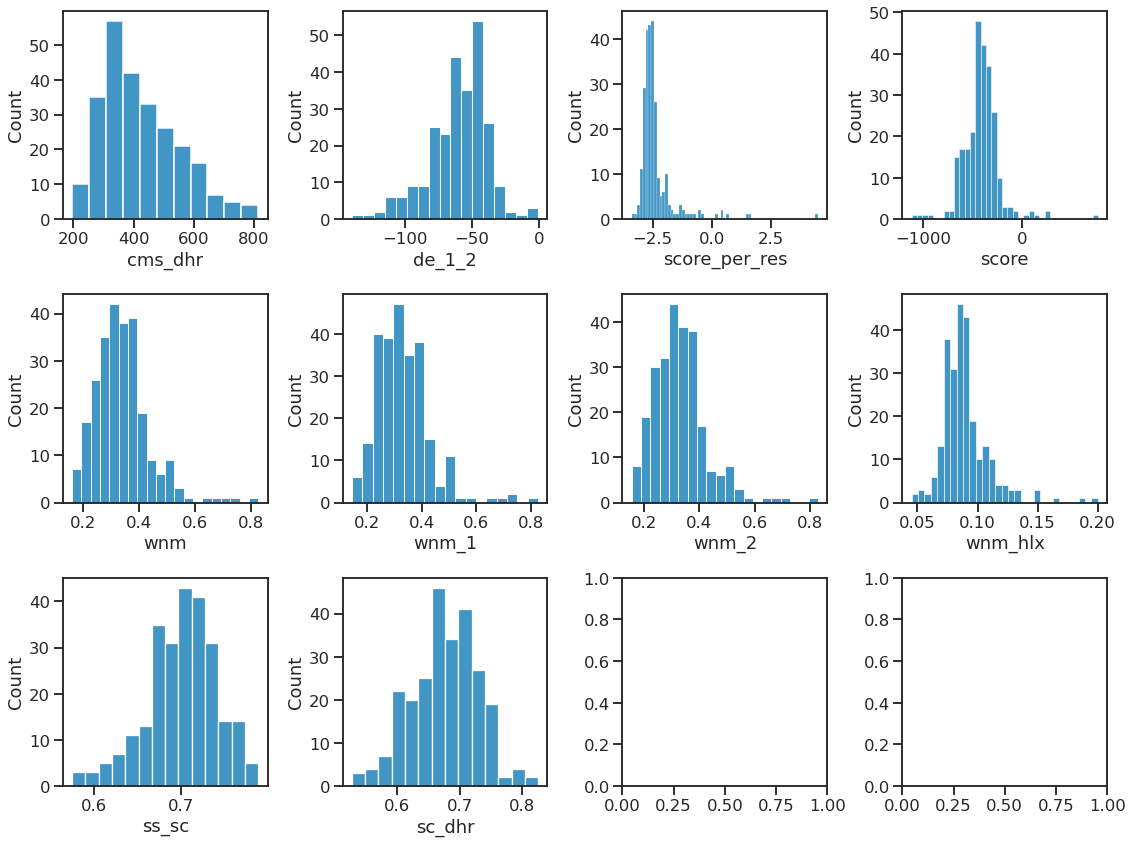

In [8]:
histplot_df(scores_df)